In [2]:
#from sklearn.neighbors import NearestNeighbors
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pa
import json as js
import networkx as nx
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

In [3]:
file = open('export.json',)
data = js.load(file)
elements = data["elements"]
file.close()

In [4]:
def haversine(point1, point2):
    lat1, lon1, lat2, lon2 = map(radians, [point1[0], point1[1], point2[0], point2[1]])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of the Earth in kilometers. Use 3956 for miles. Determines return value units.
    return round(c * r,2)

In [5]:
#regroupe les coordonnées en couple
#nodesMap = {id, [lat, lon, stations, marqué]}
nodesMap = {}
for e in elements:
    if (e["type"] == "node"):
        if("tags" in e):
            if("name" in e["tags"]):
                if(e["tags"]["name"].startswith("Aire")):
                    point = [e["lat"],e["lon"],1,0,e["tags"]["name"]]
                else:
                    point = [e["lat"],e["lon"],0,0,None]
            else:
                point = [e["lat"],e["lon"],0,0,None]

        else:
            point = [e["lat"],e["lon"],0,0,None]
        # ajout dans le dictionnaire
        nodesMap.update({e["id"] : point})

In [6]:

motorway_nodes = {}  # Dictionnaire pour les nœuds associés à motorway
trunk_nodes = {}  # Dictionnaire pour les nœuds associés à trunk
other_area_nodes = {}  # Dictionnaire pour les nœuds associés à d'autres types d'aires

way_nodes = {} # [node_id, way_id]
way_stations = {} # [node_id, way_id]

for e in elements:
    same = False
    if e["type"] == "way" and "tags" in e and "name" in e["tags"] and e["tags"]["name"].startswith("Aire"):
        
        for node in nodesMap.items():
            if node[1][2] == 1:
                if node[1][4] == e["tags"]["name"]:
                    same = True

        if same == False:
            way_stations.update({e["nodes"][1] : e["id"]})

    elif e["type"] == "way" and "highway" in e["tags"]:
        if e["tags"]["highway"] == "motorway":
            motorway_nodes[e["id"]] = e
        elif e["tags"]["highway"] == "trunk":
            trunk_nodes[e["id"]] = e


for node in way_stations.items():
    nodesMap.update({node[0] : [nodesMap[node[0]][0], nodesMap[node[0]][1], 1, 0]})
    other_area_nodes.update({node[0] : [nodesMap[node[0]][0], nodesMap[node[0]][1], 1, 0]})


In [7]:
# Pour chaque aire, cherche la motorway ou trunk la plus proche

for node_id, node_data in other_area_nodes.items():
    
    if node_data[2] == 1:  # Si c'est un noeud aire
        min_distance_motorway = float("inf") # on initialise la distance à l'infini
        closest_motorway = None # on initialise la motorway la plus proche à None

        # de même pour les trunks
        min_distance_trunk = float("inf")
        closest_trunk = None

        # pour chaque motorway, on cherche le noeud le plus proche
        for motorway_id, motorway_data in motorway_nodes.items():

            way_nodes = motorway_data["nodes"] # la liste des nœuds de la way associée à motorway

            first_node = nodesMap.get(way_nodes[0]) # on récupère le premier nœud dans la way

            if first_node:
                distance = haversine([node_data[0], node_data[1]], [first_node[0], first_node[1]]) # on calcule la distance entre le noeud aire et le premier noeud de la way
                
                if distance < min_distance_motorway: # si la distance est inférieure à la distance minimale
                    min_distance_motorway = distance
                    closest_motorway = motorway_data

        # de même pour les trunks	
        for trunk_id, trunk_data in trunk_nodes.items():

            way_nodes = trunk_data["nodes"]

            first_node = nodesMap.get(way_nodes[0])

            if first_node:
                distance = haversine([node_data[0], node_data[1]], [first_node[0], first_node[1]])
                if distance < min_distance_trunk:
                    min_distance_trunk = distance
                    closest_trunk = trunk_data

        # On regarde si la motorway ou le trunk le plus proche est à côté du point
        if min_distance_motorway < 2 or min_distance_trunk < 2:

            aire_way_id = way_stations.get(node_id) # on récupère l'id de la way associée à l'aire

            
            if aire_way_id:
                for element in elements:
                    if element["type"] == "way" and element["id"] == aire_way_id: # on cherche la way associée à l'aire
                        for i in element["nodes"]:
                            if i == node_id: # On supprime le noeud dans son aire
                                element["nodes"].remove(i)

            # On ajoute le noeud à la motorway ou au trunk le plus proche
            for element in elements:
                if element["type"] == "way" and element["id"] == closest_motorway["id"]:
                    if node_id not in element["nodes"]:
                        element["nodes"].append(node_id)
                            

            # print("Node ID:", node_id)
            # print("Aire Name:", node_data[0], node_data[1])
            # if closest_motorway:
            #     print("Closest Motorway:", closest_motorway["id"])
            #     print("Distance to Motorway:", min_distance_motorway)
            # if closest_trunk:
            #     print("Closest Trunk:", closest_trunk["id"])
            #     print("Distance to Trunk:", min_distance_trunk)
            # print("---")


output_file = "output.json"

# On ecrit le resultat dans le fichier output.json
with open(output_file, "w") as f:
    js.dump(data, f, indent=4)


In [8]:
file = open('output.json',)
data = js.load(file)
elements = data["elements"]
file.close()

In [9]:
# parcourir les types "way"
# noSimpleGraph : {idNode : {
#        nextNodes : [node1,node2,...],
#        prevNodes : [node1,node2,...]
#}}
# 

start_nodes = set()  # Créez un ensemble pour stocker les nœuds de départ

for e in elements:
    if e["type"] == "way":
        start_node = e["nodes"][0]  # Le premier nœud du chemin est le nœud de départ
        start_nodes.add(start_node)

noSimpleGraph = {}

def updateGraph(idNode,nextNode,prevNode):
    
    if nextNode != None:
        noSimpleGraph[idNode]["nextNodes"].append(nextNode)
    if prevNode != None:
        noSimpleGraph[idNode]["prevNodes"].append(prevNode)

        
for nodes in elements:
    if (nodes["type"] == "way"):
        for i in range(len(nodes["nodes"])):
            idNode = nodes["nodes"][i] 

            if idNode not in noSimpleGraph:
                noSimpleGraph.update({idNode : {"nextNodes" :[],
                                       "prevNodes" : []}})

            if i == 0:
               updateGraph(idNode,nodes["nodes"][i+1],None)

            elif i == (len(nodes["nodes"])-1):
                updateGraph(idNode,None,nodes["nodes"][i-1])
            else:
                updateGraph(idNode,nodes["nodes"][i+1],nodes["nodes"][i-1])
            
#print(noSimpleGraph)


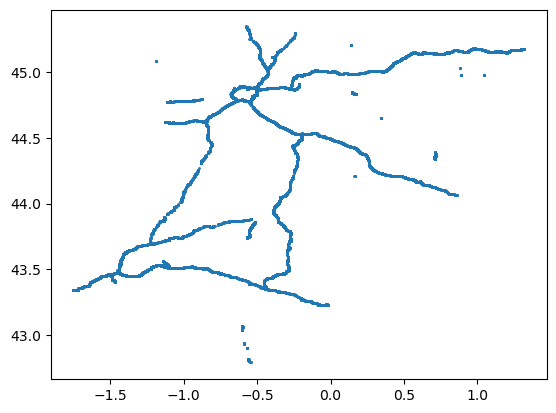

In [10]:
xpoints = []
ypoints = []
for node in noSimpleGraph.items():

        xpoints.append(nodesMap[node[0]][0])
        ypoints.append(nodesMap[node[0]][1])

latitude = np.array(xpoints)
longitude = np.array(ypoints)

plt.scatter(longitude,latitude,s=1)
plt.show()

In [11]:
def updateSimpleGraph(graph,idNode):
    if idNode not in graph:
        graph.update({idNode : {"nextNodes" :[],
                                       "prevNodes" : []}})
    return graph

In [12]:
# fonction pour trouver les prochains nœuds de la station
def nextStation(graph, startNode, nodesMap):
    newGraph = {}
    visitedNodes = set()
    stack = [(startNode, None, 0)]

    while stack:
        node, lastStationNode, lastDistance = stack.pop()

        if node not in visitedNodes:
            visitedNodes.add(node)
            if nodesMap[node][2] == 1:
                updateSimpleGraph(newGraph, node)
                if lastStationNode is not None:
                    newGraph[lastStationNode]["nextNodes"].append([node, lastDistance])
                    newGraph[node]["prevNodes"].append([lastStationNode, lastDistance])
                lastStationNode = node
                lastDistance = 0.0

            for nextNode in graph.get(node, {}).get("nextNodes", []):
                if nextNode not in visitedNodes:
                    distance = haversine([nodesMap[node][0], nodesMap[node][1]], [nodesMap[nextNode][0], nodesMap[nextNode][1]])
                    distance = round(distance, 2)
                    stack.append((nextNode, lastStationNode, round(lastDistance + distance, 2)))

    return newGraph

newGraphs = {}
visitedNodes = set()

for node_id, node_data in nodesMap.items():
    if node_data[2] == 1:
        if node_id not in visitedNodes:
            newGraph = nextStation(noSimpleGraph, node_id, nodesMap)
            newGraphs[node_id] = newGraph


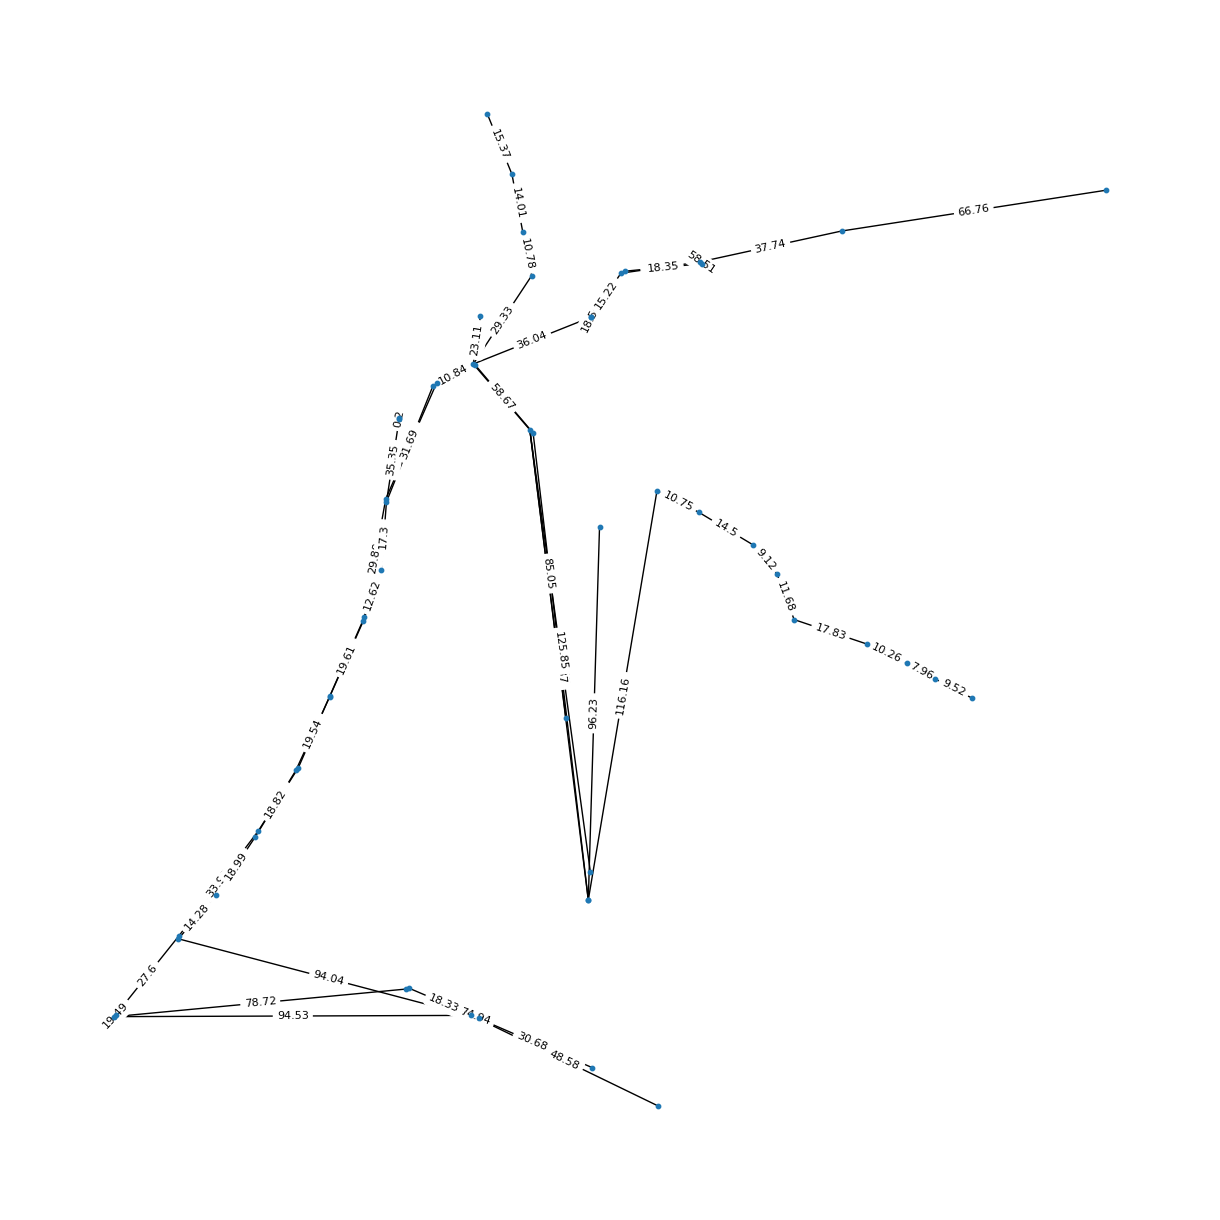

In [13]:
G = nx.Graph()

for node, data in newGraph.items():
    G.add_node(node, latitude=nodesMap[node][0], longitude=nodesMap[node][1])

for node, data in newGraph.items():
    for next_node, distance in data.get("nextNodes", []):
        G.add_edge(node, next_node, distance=distance)

node_positions = {node: (data['longitude'], data['latitude']) for node, data in G.nodes(data=True)}

edge_distances = nx.get_edge_attributes(G, 'distance')

plt.figure(figsize=(12, 12))
nx.draw(G, pos=node_positions, with_labels=False, node_size=10)
nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_distances, font_size=8)
plt.show()

In [15]:
import numpy as np

def floydWarshall(graph):
    num_nodes = len(graph)
    matrix = {node: {} for node in graph}

    # On utilise un dictionnaire pour stocker les index des nœuds pour pouvoir facilement faire des requêtes
    indexes = {node: idx for idx, node in enumerate(graph)}

    for aire in graph:
        if graph[aire]["prevNodes"]:
            neighbour1, distance1 = graph[aire]["prevNodes"][0]
            matrix[aire][neighbour1] = distance1
        if graph[aire]["nextNodes"]:
            neighbour2, distance2 = graph[aire]["nextNodes"][0]
            matrix[aire][neighbour2] = distance2

    for k in graph:
        for i in graph:
            for j in graph:
                if i != j:
                    new_distance = matrix[i].get(j, float('inf'))
                    matrix[i][j] = min(new_distance, matrix[i].get(k, float('inf')) + matrix[k].get(j, float('inf')))

    return matrix

result = floydWarshall(newGraph)
print(result)


{10977936133: {1452259911: 96.23, 987039211: inf, 36133148: inf, 554496341: inf, 550518935: inf, 458873218: inf, 557080084: inf, 555047649: inf, 1446015661: inf, 458877558: inf, 318182389: inf, 245469945: inf, 513717312: inf, 736942879: inf, 1883450379: inf, 1378466140: inf, 1832241426: inf, 1307011774: inf, 420592074: inf, 459485201: inf, 298367767: inf, 1582689484: inf, 1411629747: inf, 1582689432: inf, 1411631973: inf, 6860616242: inf, 726636010: inf, 1582671023: inf, 1307014518: inf, 1629414084: inf, 1184659264: inf, 1184683816: inf, 4675267560: inf, 101439017: inf, 2535235614: inf, 5315534315: inf, 21463090: inf, 245469652: inf, 21462872: inf, 1893894292: inf, 5761204260: inf, 2587088569: inf, 318151675: inf, 1143005916: inf, 1285330579: inf, 6829109389: inf, 244598847: inf, 315104887: inf, 313750636: inf, 315104278: inf, 257156240: inf, 313582913: inf, 414570837: inf, 313753580: inf, 249778863: inf, 5478275294: inf}, 1452259911: {10977936133: 96.23, 987039211: inf, 36133148: inf,

In [46]:
gPrime = {}


#Créer le graphe G' à partir du resultat de floydWarshall. Ce nouveau graphe sera utilisé par les algo EnsembleDominant
def transformGraph(dist):
    for sommet in result : 
        gPrime.update({sommet : []})
        for voisin in result[sommet]:
            if result[sommet][voisin]<= dist and result[sommet][voisin]!= float('inf') :
                gPrime[sommet].append(voisin)
    return gPrime

transformGraph(60)
#print(gPrime)

{10977936133: [],
 1452259911: [],
 987039211: [36133148, 554496341, 550518935, 458873218],
 36133148: [987039211, 554496341, 550518935, 458873218, 557080084],
 554496341: [36133148,
  550518935,
  987039211,
  458873218,
  557080084,
  555047649,
  1446015661],
 550518935: [554496341,
  458873218,
  987039211,
  36133148,
  557080084,
  555047649,
  1446015661,
  458877558],
 458873218: [550518935,
  557080084,
  987039211,
  36133148,
  554496341,
  555047649,
  1446015661,
  458877558],
 557080084: [458873218,
  555047649,
  36133148,
  554496341,
  550518935,
  1446015661,
  458877558],
 555047649: [557080084,
  1446015661,
  554496341,
  550518935,
  458873218,
  458877558],
 1446015661: [555047649,
  458877558,
  554496341,
  550518935,
  458873218,
  557080084],
 458877558: [1446015661, 550518935, 458873218, 557080084, 555047649],
 318182389: [245469945, 513717312],
 245469945: [318182389, 513717312, 736942879],
 513717312: [245469945, 736942879, 318182389],
 736942879: [5137173

In [14]:
def stationsOnWay(graph, way, stations):
    visited = set() # Créez un ensemble pour stocker les nœuds visités
    stack = [way[0]] # Créez une pile pour stocker les nœuds à visiter
    print(f"Chemin initialisé au noeud {way[0]}.") # Affichez le nœud de départ

    while stack: # Tant que la pile n'est pas vide
            current_node = stack.pop()  # Nœud en haut de la pile
            visited.add(current_node)  # Marquer le nœud comme visité

            # Vérifier si le nœud courant est dans la liste des stations
            if current_node in stations:
                print(f"La station {current_node} se trouve sur le chemin.")

            # Si le nœud courant est le nœud de fin, recherche terminée
            if current_node == way[1]:
                print(f"Noeud {way[1]} atteint, chemin parcouru.")
                break

            # Ajouter les nœuds voisins non visités à la pile
            for next_node in graph[current_node]['nextNodes']:
                if next_node not in visited:
                    stack.append(next_node)


graph = noSimpleGraph
way = [9576155790, 7509397404]
stations = [node_id for node_id, data in nodesMap.items() if data[2] == 1]